# Convolución con MNIST

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Inicialización de hiperparámetros

In [2]:
num_classes = 10
num_epochs = 5 # Cantidad de veces que todo el dataset para por la red
batch_size_train = 64 # Cantidad de muestras que se utiliza en cada iteración
batch_size_test = 1000
momentum = 0.9 # Indica cuánto de la velocidad pasada se acumula en la nueva actualización
learning_rate = 0.001
log_interval = 100 # Auxiliar: cada cuántas iteraciones imprime información del entrenamiento

## Descarga y preparación del dataset

In [3]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='data',
                                          train=True, # Obtenemos la data de entrenamiento
                                          # transforms.ToTensor(): convierte la imagen a tensor de PyTorch y escala los valores de [0,255] a [0,1]
                                          # transforms.Normalize(): normaliza los píxeles para que queden entre [-1, 1]
                                          transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]),
                                          download=True)

print("Data entrenamiento:", len(train_dataset))

test_dataset = torchvision.datasets.MNIST(root='data',
                                          train=False, # Obtenemos la data de test
                                          transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,),(0.5,))]))

print("Data test:", len(test_dataset))

# Data loader
## Hacemos uso de data loaders para dividir la data en mini-batches
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size_train,
                                           shuffle=True)

print("\nN° iteraciones entrenamiento:", len(train_loader))

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size_test,
                                          shuffle=False)

print("N° iteraciones test:", len(test_loader))

100%|██████████| 9.91M/9.91M [00:00<00:00, 59.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.4MB/s]

Data entrenamiento: 60000
Data test: 10000

N° iteraciones entrenamiento: 938
N° iteraciones test: 10


In [4]:
# Pero, ¿cuántas imágenes cargamos en cada iteración?
print("Para entrenamiento:", round(len(train_dataset)/len(train_loader)))
print("Para test:", round(len(test_dataset)/len(test_loader)))

Para entrenamiento: 64
Para test: 1000


In [5]:
# Podemos visualizar un mini-batch
batch = next(enumerate(train_loader))
print(batch)
_, (imagenes, etiquetas) = batch
print(imagenes.shape)

(0, [tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [

Numero de batch: 0
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


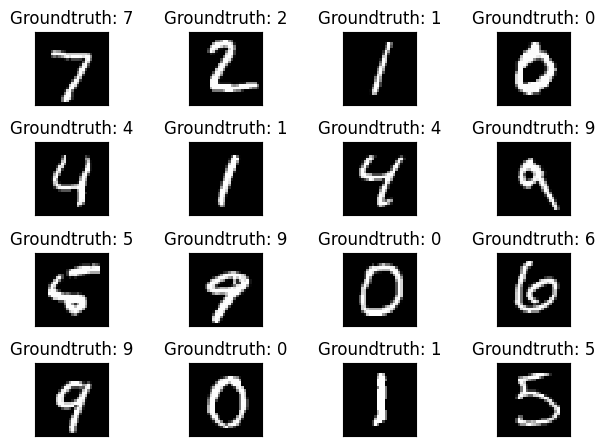

In [6]:
#examples = enumerate(train_loader)
examples = enumerate(test_loader)

batchId, (exampleData, exampleTargets) = next(examples) #Next batch
print('Numero de batch: {}'.format(batchId))
print(exampleData.shape)
print(exampleTargets.shape)

import matplotlib.pyplot as plt

#Show the first 6 elements in the batch
plt.figure()
for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.tight_layout()
  plt.imshow(exampleData[i][0], cmap='gray', interpolation='none')
  plt.title('Groundtruth: {}'.format(exampleTargets[i]))
  plt.xticks([])
  plt.yticks([])

In [ ]:
print((exampleData[0][0]).shape)

torch.Size([28, 28])


## Creación de la red neuronal

Idea de convolución:

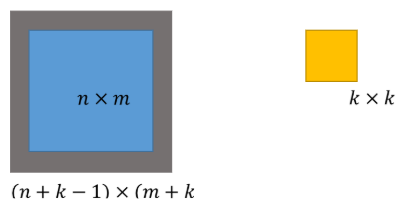

Capas de convolución:

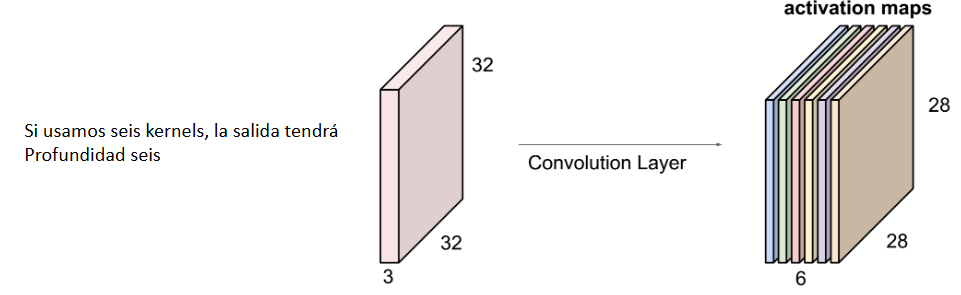

Capas de Pooling:

* https://docs.google.com/presentation/d/1ZcNsIVvVCOALSUKL9XSmTJfaWCcdpOJq/edit?slide=id.p45#slide=id.p45
* https://www.nature.com/articles/s41598-024-51258-6#:~:text=Max%20pooling%20is%20a%20commonly,each%20small%20window%20or%20region.

SGD con Momentum:
* https://docs.google.com/presentation/d/1MhhleSbMabAWLLO0BlxLUnvBCTsMDaYk/edit?slide=id.p51#slide=id.p51
* https://medium.com/@piyushkashyap045/understanding-sgd-with-momentum-in-deep-learning-a-beginner-friendly-guide-0252ede605b4

> Los kernels siempre son número impares

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    # Capas convolucionales
    ## Toma imágenes de 1 canal (grises) y produce 16 mapas de activación
    ## Recibe: (64, 1, 28, 28)
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
    ## Toma esos 16 mapas de activación y genera 32 nuevos mapas
    ## Recibe: (64, 16, 28, 28)
    self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
    ## Toma los 32 mapas y genera 64. No tiene padding, reduce el tamaño espacial
    self.conv3 = nn.Conv2d(32, 64, kernel_size=3)

    # Capas densas (fully-connected)
    ## La entrada es un vector de tamaño 1600
    self.fc1 = nn.Linear(5*5*64, 256)
    ## La salida son 10 clases (del dataset)
    self.fc2 = nn.Linear(256,10)

  def forward(self, x):
    # x es (64, 1, 28, 28)
    x = F.relu(F.max_pool2d(self.conv1(x), 2)) # de 28 × 28 × 1 → 14 × 14 × 16
    x = F.relu(F.max_pool2d(self.conv2(x), 2)) # de 14 × 14 × 16 → 7 × 7 × 32
    x = F.relu(self.conv3(x)) # de 7 × 7 × 32 → 5 × 5 × 64
    x = x.view(-1, 5*5*64) # Aplana el vector = 1600
    x = F.relu(self.fc1(x)) # de 1600 a 256
    x = self.fc2(x) # de 256 a 10
    return F.log_softmax(x) # función de densidad de probabilidades logaritmicas

network = Net()
# Usaremos SGD con momentum
optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

network = network.to(device)

In [8]:
import torchsummary as ts

print(network)
ts.summary(network.to(device), (1, 28, 28), device='cuda')

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
            Conv2d-2           [-1, 32, 14, 14]           4,640
            Conv2d-3             [-1, 64, 5, 5]          18,496
            Linear-4                  [-1, 256]         409,856
            Linear-5                   [-1, 10]           2,570
Total params: 435,722
Trainable params: 435,722
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params si

/tmp/ipython-input-190725787.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x) # función de densidad de probabilidades logaritmicas



Utilizaremos Negative Log-Likelihood como función de pérdida:
* Similar a CrossEntropyLoss (espera valores de predicción sin procesar), pero NLL_Loss espera probabilidades logarítmicas.
* Intuición: Queremos que el modelo asigne alta probabilidad a la clase correcta:
  * Si la red predice probabilidad alta para la etiqueta correcta, la pérdida es pequeña.
  * Si la red predice probabilidad baja, la pérdida es grande.

https://towardsdatascience.com/cross-entropy-negative-log-likelihood-and-all-that-jazz-47a95bd2e81/

In [9]:
train_losses = []
train_counter = []
test_losses = []

# Puntos en los cuales se medirá el test (al inicio y final de cada epoch)
test_counter = [i*len(train_loader.dataset) for i in range(num_epochs+1)]

# Función para entrenar una época
def train(network, optimizer,  epoch):
  network.train() # Modo entrenamiento

  for batchId, (data, target) in enumerate(train_loader): # Iterar sobre los batches
    data = data.to(device)
    target = target.to(device)

    # Feedforward pass
    optimizer.zero_grad() # Reiniciamos gradientes
    output = network(data) # Forward pass
    loss = F.nll_loss(output, target) # Porque la red devuelve log_softmax
    loss.backward() # Backpropagation
    optimizer.step() # Actualizar parámetros

    # Imprimimos el accuracy y pérdida en cada paso del batch
    # Guardamos los checkpoints del modelo y optimizador
    if batchId % log_interval == 0:
      print('Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batchId*len(data), len(train_loader.dataset), 100.*batchId/len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append((batchId*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(),'model.pth')
      torch.save(optimizer.state_dict(), 'optimizer.pth')


# Testing
def test(network):

  network.eval() #Test mode
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in test_loader:
      data = data.to(device)
      target = target.to(device)
      output = network(data)
      test_loss += F.nll_loss(output, target, reduction='sum').item() # Devuelve las sumas de todas las pérdidas del batch
      pred = output.data.max(1, keepdim=True)[1] # Retorna la clase con mayor probabilidad
      correct += pred.eq(target.data.view_as(pred)).sum() # Cuenta aciertos

  length = len(test_loader.dataset)
  test_loss /= length
  test_losses.append(test_loss)
  print('\nTest set: Avg. Loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Error: {:.3f}% \n'.format(test_loss, correct, len(test_loader.dataset), 100.*correct/len(test_loader.dataset), 100.*(length-correct)/length))

In [10]:
test(network)
for epoch in range(1, num_epochs + 1):
  train(network, optimizer, epoch)
  test(network)

/tmp/ipython-input-190725787.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x) # función de densidad de probabilidades logaritmicas



Test set: Avg. Loss: 2.3038, Accuracy: 767/10000 (8%), Error: 92.330% 

Train epoch: 1 [0/60000 (0%)]	Loss: 2.312333
Train epoch: 1 [6400/60000 (11%)]	Loss: 2.295416
Train epoch: 1 [12800/60000 (21%)]	Loss: 2.264901
Train epoch: 1 [19200/60000 (32%)]	Loss: 2.199967
Train epoch: 1 [25600/60000 (43%)]	Loss: 1.945506
Train epoch: 1 [32000/60000 (53%)]	Loss: 1.023545
Train epoch: 1 [38400/60000 (64%)]	Loss: 0.406809
Train epoch: 1 [44800/60000 (75%)]	Loss: 0.362216
Train epoch: 1 [51200/60000 (85%)]	Loss: 0.318343
Train epoch: 1 [57600/60000 (96%)]	Loss: 0.295587

Test set: Avg. Loss: 0.3305, Accuracy: 9045/10000 (90%), Error: 9.550% 

Train epoch: 2 [0/60000 (0%)]	Loss: 0.357526
Train epoch: 2 [6400/60000 (11%)]	Loss: 0.167729
Train epoch: 2 [12800/60000 (21%)]	Loss: 0.322513
Train epoch: 2 [19200/60000 (32%)]	Loss: 0.101724
Train epoch: 2 [25600/60000 (43%)]	Loss: 0.317577
Train epoch: 2 [32000/60000 (53%)]	Loss: 0.293905
Train epoch: 2 [38400/60000 (64%)]	Loss: 0.173398
Train epoch: 2 

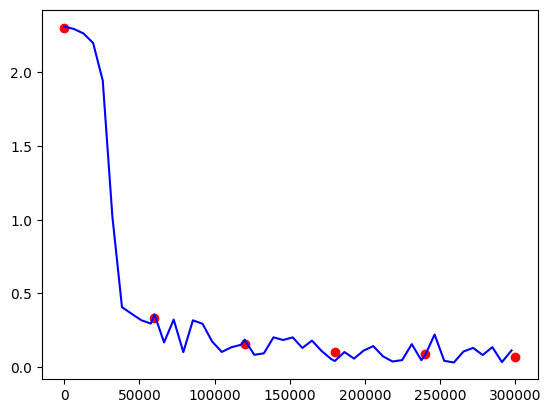

In [11]:
plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.show()

Análisis:

* Al inicio la pérdida es alta, porque la red predice casi aleatoriamente.
* En las primeras iteraciones, el modelo aprende rápido las características básicas de los datos.
* La pérdida se va estabializando en valores bajos. Aunque el modelo sigue refinando pero a un ritmo más lento.
* Los puntos rojos (test) son consistentes con la curva, lo que indica que la red no se está sobreajustando.

In [12]:
with torch.no_grad():
  output = network(exampleData.to(device))

/tmp/ipython-input-190725787.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x) # función de densidad de probabilidades logaritmicas


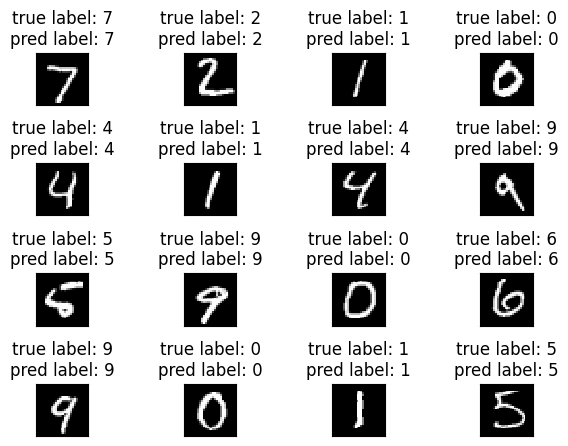

In [13]:
fig = plt.figure()
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.tight_layout()
  plt.imshow(exampleData[i][0], cmap='gray', interpolation='none')

  pred = output.data.max(1, keepdim=True)[1][i].item()
  gt = exampleTargets[i]

  plt.title(f'true label: {gt}\n' \
               f'pred label: {pred}')
  plt.xticks([])
  plt.yticks([])
plt.show()

In [14]:
# Podemos reanudar el entrenamiento desde un checkpoint
continued_network = Net()
network_state_dict = torch.load('model.pth')
continued_network.load_state_dict(network_state_dict)
continued_network = continued_network.to(device)

# Cambiamos el lr
continued_optimizer = optim.SGD(continued_network.parameters(), lr=0.0005, momentum=momentum)
optimizer_state_dict=torch.load('optimizer.pth')
continued_optimizer.load_state_dict(optimizer_state_dict)

In [15]:
# Retoma el entrenamiento 5 épocas más
for i in range(6, 10):
  test_counter.append(i*len(train_loader.dataset))
  train(continued_network, continued_optimizer, i)
  test(continued_network)

/tmp/ipython-input-190725787.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x) # función de densidad de probabilidades logaritmicas


Train epoch: 6 [0/60000 (0%)]	Loss: 0.071025
Train epoch: 6 [6400/60000 (11%)]	Loss: 0.046537
Train epoch: 6 [12800/60000 (21%)]	Loss: 0.039814
Train epoch: 6 [19200/60000 (32%)]	Loss: 0.129545
Train epoch: 6 [25600/60000 (43%)]	Loss: 0.045449
Train epoch: 6 [32000/60000 (53%)]	Loss: 0.216598
Train epoch: 6 [38400/60000 (64%)]	Loss: 0.089648
Train epoch: 6 [44800/60000 (75%)]	Loss: 0.060816
Train epoch: 6 [51200/60000 (85%)]	Loss: 0.071975
Train epoch: 6 [57600/60000 (96%)]	Loss: 0.077585

Test set: Avg. Loss: 0.0699, Accuracy: 9757/10000 (98%), Error: 2.430% 

Train epoch: 7 [0/60000 (0%)]	Loss: 0.048851
Train epoch: 7 [6400/60000 (11%)]	Loss: 0.032054
Train epoch: 7 [12800/60000 (21%)]	Loss: 0.123898
Train epoch: 7 [19200/60000 (32%)]	Loss: 0.044189
Train epoch: 7 [25600/60000 (43%)]	Loss: 0.023972
Train epoch: 7 [32000/60000 (53%)]	Loss: 0.112644
Train epoch: 7 [38400/60000 (64%)]	Loss: 0.081196
Train epoch: 7 [44800/60000 (75%)]	Loss: 0.031876
Train epoch: 7 [51200/60000 (85%)]	Los

10
10


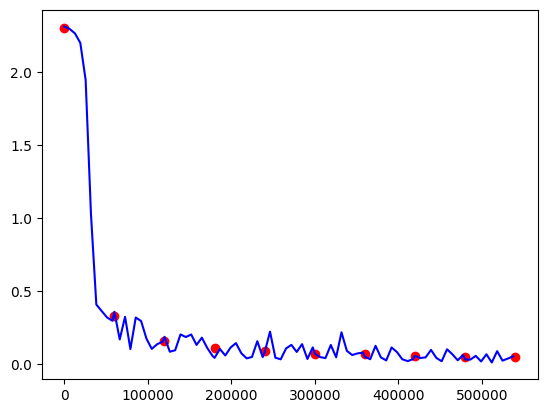

In [16]:
print(len(test_counter))
print(len(test_losses))

plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.show()

Análisis:

* El cambio del LR sirvió para pulir el entrenamiento.
* Con un learning rate más bajo el modelo aprende mejor manera las representaciones.
* La pérdida no baja mucho más, pero si se mantiene estable.

In [18]:
# Función para obtener predicciones
def get_predictions(model, iterator, device):

    # Desactivamos el entrenamiento
    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (data, target) in iterator:
            data = data.to(device)
            y_pred = model(data)

            # Recordar que nuestra red no aplica softmax
            # Obtenemos el índice con mayor valor de salida
            #y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_pred.argmax(1, keepdim = True)

            # Almacenamos las etiquetas y el pdf de cada predicción
            labels.append(target.cpu())
            probs.append(y_pred.cpu())

    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return labels, probs

In [19]:
# Obtenemos las etiquetas y predicciones
labels, probs = get_predictions(continued_network, test_loader, device)

pred_labels = torch.argmax(probs, 1)

/tmp/ipython-input-190725787.py:33: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x) # función de densidad de probabilidades logaritmicas


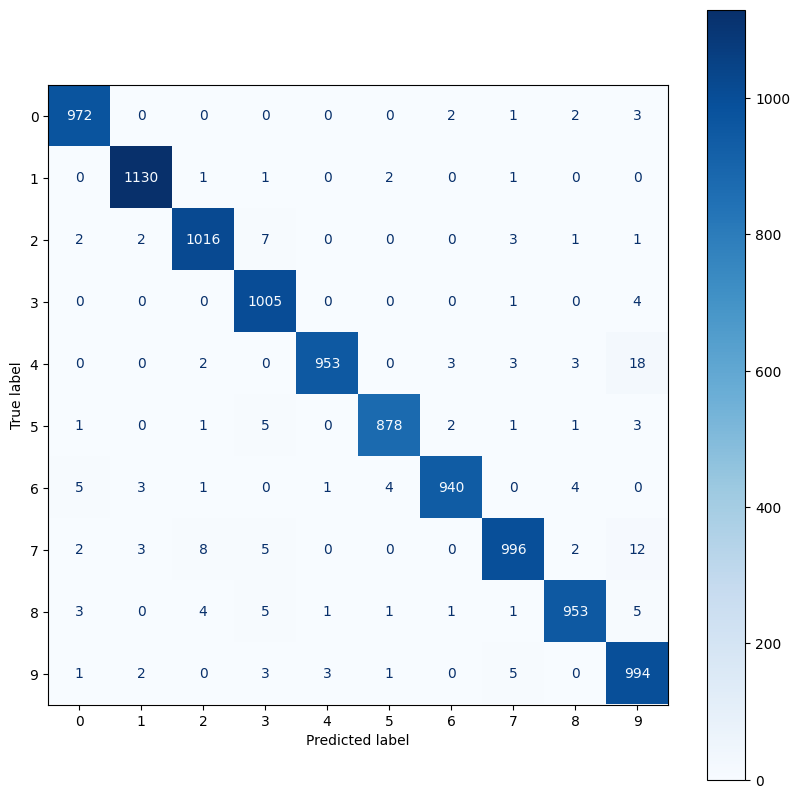

In [20]:
from sklearn import metrics

#Plot a confussion matrix
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels, pred_labels);
    cm = metrics.ConfusionMatrixDisplay(cm);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)

plot_confusion_matrix(labels, pred_labels)

Métricas de evaluación:
* Precisión: mide la exactitud de las predicciones positivas. Responde a la pregunta: «De todos los elementos que el modelo ha etiquetado como positivos, ¿cuántos eran realmente positivos?».
* Recall (sensibilidad): mide la capacidad del modelo para encontrar todos los casos positivos. Responde a la pregunta: «De todos los positivos reales, ¿cuántos identificó correctamente el modelo?».
* Puntuación F1: la media armónica de la precisión y la recuperación. Equilibra las dos métricas en un solo número, lo que la hace especialmente útil cuando la precisión y la recuperación están en conflicto.

https://medium.com/@piyushkashyap045/understanding-precision-recall-and-f1-score-metrics-ea219b908093

In [21]:
print(metrics.classification_report(labels, pred_labels, digits=6))

              precision    recall  f1-score   support

           0   0.985801  0.991837  0.988810       980
           1   0.991228  0.995595  0.993407      1135
           2   0.983543  0.984496  0.984019      1032
           3   0.974782  0.995050  0.984811      1010
           4   0.994781  0.970468  0.982474       982
           5   0.990971  0.984305  0.987627       892
           6   0.991561  0.981211  0.986359       958
           7   0.984190  0.968872  0.976471      1028
           8   0.986542  0.978439  0.982474       974
           9   0.955769  0.985134  0.970229      1009

    accuracy                       0.983700     10000
   macro avg   0.983917  0.983541  0.983668     10000
weighted avg   0.983842  0.983700  0.983710     10000



Análisis:

* De 10,000 imágenes, ~9,841 fueron clasificadas correctamente.
* macro avg: promedio simple entre las clases (trata todas las clases igual). ~0.984 en todas las métricas.
* weighted avg: promedio ponderado por el número de ejemplos por clase. Similar (~0.984) porque MNIST es balanceado.